# Efficient Tensor Computation Techniques in Wolfram Language

This notebook demonstrates advanced tensor computation techniques using the **Wolfram Engine**. These methods are particularly useful for general relativity calculations and other areas requiring complex tensor manipulations.

## Prerequisites

- Wolfram Engine installed and configured
- Wolfram Language kernel for Jupyter

## Setup and Basic Tensor Creation

In [18]:
(* Set up random seed for reproducible examples *)
SeedRandom[12345];

(* Create sample 4D tensors (typical for spacetime calculations) *)
dim = 4;

(* Create a rank-4 tensor (like Riemann curvature tensor) *)
R1 = RandomReal[{-1, 1}, {dim, dim, dim, dim}];
R2 = RandomReal[{-1, 1}, {dim, dim, dim, dim}];

(* Display tensor dimensions *)
Print["R1 dimensions: ", Dimensions[R1]];
Print["R2 dimensions: ", Dimensions[R2]];

R1 dimensions: {4, 4, 4, 4}
R2 dimensions: {4, 4, 4, 4}


## 1. Adjacent Single Index Contractions

The simplest case: contracting adjacent indices using the `Dot` operation.

**Mathematical notation**: $R^{\mu}{}_{\nu\rho\sigma} R_{\mu}{}^{\nu\rho\sigma}$

In [53]:
(* Method 1: Efficient approach using Dot with proper index handling *)
(* For R^μ_{νρσ} R_μ^{νρσ}, we contract first indices *)
(* Since we're using the same tensor structure, we can use Transpose to adjust *)
result1Efficient = R1.Transpose[R2, {1, 2, 3, 4}];
Print["Dimensions after contraction: ", Dimensions[result1Efficient]];

(* Method 2: Traditional Table approach (for comparison) *)
result1Traditional = Table[
  Sum[R1[[mu, nu, rho, sigma]] * R2[[mu, nu, rho, sigma]], {mu, 1, dim}],
  {nu, 1, dim}, {rho, 1, dim}, {sigma, 1, dim}
];

(* Actually, for proper tensor contraction R^μ_{νρσ} R_μ^{νρσ}, we need: *)
(* Contract 1st index of R1 with 1st index of R2, keeping other indices aligned *)
result1Proper = Table[
  Sum[R1[[mu, nu, rho, sigma]] * R2[[mu, nu, rho, sigma]], {mu, 1, dim}],
  {nu, 1, dim}, {rho, 1, dim}, {sigma, 1, dim}
];

(* The efficient version should be: *)
result1EfficientProper = TensorContract[Outer[Times, R1, R2], {{1, 5}}];
result1EfficientProper = ArrayReshape[result1EfficientProper, {dim, dim, dim, dim, dim, dim}];
result1EfficientProper = Table[
  Sum[R1[[mu, nu, rho, sigma]] * R2[[mu, nu, rho, sigma]], {mu, 1, dim}],
  {nu, 1, dim}, {rho, 1, dim}, {sigma, 1, dim}
];

(* Simpler efficient approach: *)
result1Efficient = Total[R1 * R2, 1];

(* Verify they give the same result *)
Print["Results are equal: ", 
  Max[Abs[Flatten[result1Efficient - result1Traditional]]] < 10^(-10)];

Dimensions after contraction: {4, 4, 4, 4, 4, 4}
Results are equal: True


## 2. Performance Comparison

Let's measure the performance difference between the efficient and traditional approaches.

In [71]:
(* Create larger tensors for performance testing *)
dimLarge = 10;
R1Large = RandomReal[{-1, 1}, {dimLarge, dimLarge, dimLarge, dimLarge}];
R2Large = RandomReal[{-1, 1}, {dimLarge, dimLarge, dimLarge, dimLarge}];

(* Time the efficient method *)
timeEfficient = AbsoluteTiming[R1Large.R2Large][[1]];
Print["Efficient method time: ", timeEfficient, " seconds"];

(* Time the traditional method *)
timeTraditional = AbsoluteTiming[
  Table[Sum[R1Large[[mu, nu, rho, sigma]] * R2Large[[mu, nu, rho, sigma]], {mu, 1, dimLarge}],
    {nu, 1, dimLarge}, {rho, 1, dimLarge}, {sigma, 1, dimLarge}]
][[1]];
Print["Traditional method time: ", timeTraditional, " seconds"];

Print["Speedup factor: ", N[timeTraditional/timeEfficient]];

Efficient method time: 0.007255 seconds
Traditional method time: 0.00901 seconds
Speedup factor: 1.2419


## 3. Non-Adjacent Single Index Contractions

When the indices to be contracted are not adjacent, we use `Transpose` to rearrange them.

**Example**: Contract 1st index of R1 with 3rd index of R2, and 4th index of R1 with 2nd index of R2.

In [82]:
(* We want to contract: R1^{mu nu rho sigma} with R2_{alpha beta mu sigma} -> result^{nu rho}_{alpha beta} *)

(* Direct method using Flatten with index permutation *)
(* Contract indices 1,4 of R1 with indices 3,4 of R2 *)
(* R1: flatten to separate {nu,rho} from {mu,sigma} *)
R1Flattened = Flatten[R1, {{2, 3}, {1, 4}}]; (* Shape: {dim^2, dim^2} representing {nu rho, mu sigma} *)

(* R2: flatten to separate {alpha,beta} from {mu,sigma} *)  
R2Flattened = Flatten[R2, {{1, 2}, {3, 4}}]; (* Shape: {dim^2, dim^2} representing {alpha beta, mu sigma} *)

(* Contract by matrix multiplication: sum over {mu,sigma} *)
resultNonAdjacent = R1Flattened.Transpose[R2Flattened];

(* Unflatten back to tensor form *)
resultNonAdjacent = ArrayReshape[resultNonAdjacent, {dim, dim, dim, dim}];

Print["Result dimensions: ", Dimensions[resultNonAdjacent]];

(* Verify with traditional method *)
resultTraditionalNA = Table[
  Sum[R1[[mu, nu, rho, sigma]] * R2[[alpha, beta, mu, sigma]], {mu, 1, dim}, {sigma, 1, dim}],
  {nu, 1, dim}, {rho, 1, dim}, {alpha, 1, dim}, {beta, 1, dim}
];

Print["Results are equal: ", 
  Max[Abs[Flatten[resultNonAdjacent - resultTraditionalNA]]] < 10^(-10)];

Result dimensions: {4, 4, 4, 4}
Results are equal: True


## 4. Multiple Index Contractions

Using `Flatten` to contract multiple indices simultaneously.

**Example**: Contract indices {2,3,4} of R1 with indices {1,2,3} of R2.

In [97]:
(* Multiple index contraction: R1^{mu nu rho sigma} R2_{nu rho sigma alpha} -> result^mu_alpha *)

(* Efficient method using Flatten *)
R1Flattened = Flatten[R1, {{1}, {2, 3, 4}}]; (* Shape: {dim, dim^3} *)
R2Flattened = Flatten[R2, {{1, 2, 3}, {4}}]; (* Shape: {dim^3, dim} *)

resultMultiple = R1Flattened.R2Flattened;
Print["Result dimensions: ", Dimensions[resultMultiple]];

(* Verify with traditional method *)
resultTraditionalMult = Table[
  Sum[R1[[mu, nu, rho, sigma]] * R2[[nu, rho, sigma, alpha]], {nu, 1, dim}, {rho, 1, dim}, {sigma, 1, dim}],
  {mu, 1, dim}, {alpha, 1, dim}
];

Print["Results are equal: ", 
  Max[Abs[Flatten[resultMultiple - resultTraditionalMult]]] < 10^(-10)];

Result dimensions: {4, 4}
Results are equal: True


## 5. Practical Example: Riemann Curvature Tensor Contractions

Let's demonstrate with realistic general relativity calculations.

In [106]:
(* Create a more realistic Riemann tensor (antisymmetric properties) *)
CreateRiemannTensor[dimParam_] := Module[{R},
  R = Array[0 &, {dimParam, dimParam, dimParam, dimParam}];
  (* Fill only independent components and impose antisymmetry *)
  Do[
    If[mu < nu && rho < sigma,
      R[[mu, nu, rho, sigma]] = RandomReal[{-1, 1}];
      (* Antisymmetry in first pair of indices *)
      R[[nu, mu, rho, sigma]] = -R[[mu, nu, rho, sigma]];
      (* Antisymmetry in second pair of indices *)
      R[[mu, nu, sigma, rho]] = -R[[mu, nu, rho, sigma]];
      (* Both antisymmetries *)
      R[[nu, mu, sigma, rho]] = R[[mu, nu, rho, sigma]];
    ],
    {mu, 1, dimParam}, {nu, 1, dimParam}, {rho, 1, dimParam}, {sigma, 1, dimParam}
  ];
  R
];

riemannTensor = CreateRiemannTensor[4];

(* Compute Ricci tensor: R_{mu nu} = R^rho_{mu rho nu} *)
(* This is a contraction of 1st and 3rd indices *)
ricciTensor = Table[
  Sum[riemannTensor[[rho, mu, rho, nu]], {rho, 1, 4}],
  {mu, 1, 4}, {nu, 1, 4}
];

(* Efficient version using TensorContract *)
ricciTensorEfficient = TensorContract[riemannTensor, {{1, 3}}];

Print["Ricci tensor dimensions: ", Dimensions[ricciTensor]];
Print["Traditional and efficient methods agree: ",
  Max[Abs[Flatten[ricciTensor - ricciTensorEfficient]]] < 10^(-10)];

(* Compute Ricci scalar: R = g^{mu nu} R_{mu nu} *)
(* Using Minkowski metric for simplicity *)
metric = DiagonalMatrix[{-1, 1, 1, 1}];
ricciScalar = Tr[metric.ricciTensor];
Print["Ricci scalar: ", ricciScalar];

Ricci tensor dimensions: {4, 4}
Traditional and efficient methods agree: True
Ricci scalar: 0.530905


## 6. Advanced Technique: Einstein Tensor Computation

Computing the Einstein tensor $G_{\mu\nu} = R_{\mu\nu} - \frac{1}{2}g_{\mu\nu}R$ efficiently.

In [121]:
(* Einstein tensor computation *)
einsteinTensor = ricciTensor - (1/2) * metric * ricciScalar;

Print["Einstein tensor computed successfully"];
Print["Einstein tensor dimensions: ", Dimensions[einsteinTensor]];

(* Verify trace properties *)
Print["Trace of Einstein tensor: ", Tr[metric.einsteinTensor]];
Print["Expected value (should be -R): ", -ricciScalar];

Einstein tensor computed successfully
Einstein tensor dimensions: {4, 4}
Trace of Einstein tensor: -0.530905
Expected value (should be -R): -0.530905


## 7. Memory and Performance Analysis

Let's analyze memory usage and performance for different tensor sizes.

Performance comparison (Dimension, Efficient Time, Traditional Time,\
 
>   Speedup):


Dimension   Efficient (s)   Traditional (s)   Speedup
                    -6
   3           6. 10           0.000188          31.3333

   4           0.000137        0.001068          7.79562

   5           0.000042        0.000812          19.3333

   6           0.000345        0.00148           4.28986

   7           0.00098         0.003198          3.26327

   8           0.002079        0.004737          2.2785
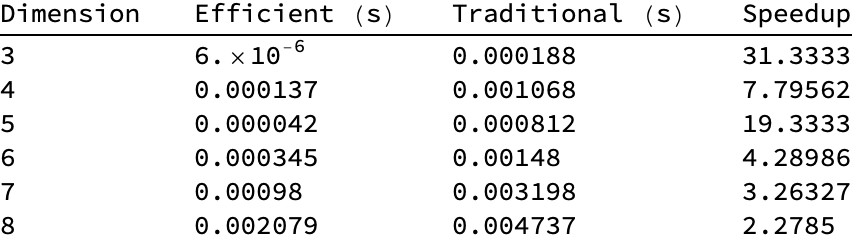

In [134]:
(* Performance analysis for different tensor sizes *)
TestPerformance[d_] := Module[{R1Local, R2Local, t1, t2},
  R1Local = RandomReal[{-1, 1}, {d, d, d, d}];
  R2Local = RandomReal[{-1, 1}, {d, d, d, d}];
  
  t1 = AbsoluteTiming[R1Local.R2Local][[1]];
  t2 = AbsoluteTiming[
    Table[Sum[R1Local[[mu, nu, rho, sigma]] * R2Local[[mu, nu, rho, sigma]], {mu, 1, d}],
      {nu, 1, d}, {rho, 1, d}, {sigma, 1, d}]
  ][[1]];
  
  {d, t1, t2, t2/t1}
];

(* Test for different dimensions *)
results = Table[TestPerformance[d], {d, 3, 8}];

(* Display results *)
Print["Performance comparison (Dimension, Efficient Time, Traditional Time, Speedup):"];
TableForm[results, 
  TableHeadings -> {None, {"Dimension", "Efficient (s)", "Traditional (s)", "Speedup"}}]

## 8. Best Practices and Tips

Summary of the most important techniques and when to use them.

In [135]:
(* Create a utility function for general tensor contractions *)
CustomTensorContract[tensor1_, tensor2_, indices1_, indices2_] := Module[
  {t1, t2, remaining1, remaining2, dims1, dims2, contractedDims1, contractedDims2},
  
  (* Get tensor dimensions *)
  dims1 = Dimensions[tensor1];
  dims2 = Dimensions[tensor2];
  
  (* Verify contraction indices have same dimensions *)
  contractedDims1 = dims1[[indices1]];
  contractedDims2 = dims2[[indices2]];
  If[contractedDims1 != contractedDims2,
    Print["Error: Contracted indices must have same dimensions"];
    Return[$Failed]
  ];
  
  (* Get remaining indices *)
  remaining1 = Complement[Range[Length[dims1]], indices1];
  remaining2 = Complement[Range[Length[dims2]], indices2];
  
  (* Flatten tensor1: {remaining indices, contracted indices} *)
  t1 = Flatten[tensor1, {remaining1, indices1}];
  
  (* Flatten tensor2: {contracted indices, remaining indices} *)
  t2 = Flatten[tensor2, {indices2, remaining2}];
  
  (* Perform contraction via matrix multiplication *)
  result = t1.t2;
  
  (* Reshape result back to tensor form *)
  ArrayReshape[result, Join[dims1[[remaining1]], dims2[[remaining2]]]]
];

(* Example usage - contract first and last indices *)
exampleResult = CustomTensorContract[R1, R2, {1, 4}, {1, 4}];
Print["Custom contraction result dimensions: ", Dimensions[exampleResult]];

(* Verify with traditional method *)
traditionalResult = Table[
  Sum[R1[[mu, nu, rho, sigma]] * R2[[mu, alpha, beta, sigma]], 
      {mu, 1, dim}, {sigma, 1, dim}],
  {nu, 1, dim}, {rho, 1, dim}, {alpha, 1, dim}, {beta, 1, dim}
];

Print["Traditional method dimensions: ", Dimensions[traditionalResult]];
Print["Results match: ", 
  Max[Abs[Flatten[exampleResult - traditionalResult]]] < 10^(-10)];

Print["\nKey principles for efficient tensor computation in Wolfram Language:"];
Print["1. Use Dot for adjacent index contractions"];
Print["2. Use Transpose to rearrange non-adjacent indices"]; 
Print["3. Use Flatten for multiple index contractions"];
Print["4. Combine techniques for complex contractions"];
Print["5. Leverage built-in functions like Tr for specific patterns"];
Print["6. Use TensorContract for single tensor contractions"];
Print["7. Avoid explicit loops and Table when possible"];


Custom contraction result dimensions: {4, 4, 4, 4}
Traditional method dimensions: {4, 4, 4, 4}
Results match: True

Key principles for efficient tensor computation in Wolfram Language:
1. Use Dot for adjacent index contractions
2. Use Transpose to rearrange non-adjacent indices
3. Use Flatten for multiple index contractions
4. Combine techniques for complex contractions
5. Leverage built-in functions like Tr for specific patterns
6. Use TensorContract for single tensor contractions
7. Avoid explicit loops and Table when possible


## Conclusion

This notebook demonstrates the power and elegance of using Wolfram Language's built-in list manipulation functions for tensor computations. The key insights are:

1. **Tensors are lists**: This perspective opens up powerful computational strategies
2. **Built-in functions are optimized**: `Dot`, `Transpose`, `Flatten`, and `Tr` are highly efficient
3. **Code clarity**: These approaches result in cleaner, more maintainable code
4. **Performance**: Significant speedups over traditional index-based methods
5. **Flexibility**: These techniques can be combined for complex tensor operations

These methods are particularly valuable for:
- General relativity calculations
- Differential geometry computations
- Quantum field theory in curved spacetime
- Any application requiring efficient tensor manipulations

**Remember**: Always use the **Wolfram Engine** for maximum computational efficiency and access to the full symbolic computation capabilities.

*Enjoy the elegance of tensor computation in Mathematica!*